In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn
from imblearn.over_sampling import RandomOverSampler

# train data provided

In [7]:
data_train = pd.read_csv('recipe_train.csv')
data_train

,name,n_steps,n_ingredients,steps,ingredients,duration_label
0,wi gal s chicken rice stove top dish made heal...,6,12,"['in saucepan , melt margarine and combine wit...","['margarine', 'olive oil', 'celery', 'onion', ...",2.0
1,irish pin oats,9,5,['melt 1 tbs butter in a small saucepan over m...,"['butter', 'pinhead oats', 'water', 'half-and-...",2.0
2,cheesy beef n biscuit casserole,15,10,"['brown ground beef , onion and green pepper',...","['ground beef', 'onion', 'green pepper', 'toma...",2.0
3,lemonade chicken oamc,10,8,"['brown chicken in oil', 'combine all ingredie...","['boneless skinless chicken', 'frozen lemonade...",2.0
4,graham and peanut butter bon bons,6,5,"['set almond bark aside', 'mix remaining ingre...","['graham cracker crumbs', 'crunchy peanut butt...",2.0
...,...,...,...,...,...,...
39995,sour cream lemon bread abm,6,13,"['in a measuring cup , combine sour cream and ...","['sour cream', 'lemon juice', 'milk', 'butter'...",1.0
39996,americanized shepherd s pie,15,16,"['preheat oven to 350 degrees', 'add potatoes ...","['potatoes', 'butter', 'milk', 'olive oil', 'o...",2.0
39997,new zealand kiwi salsa,5,8,"['place the kiwifruit , pomegranate seeds , av...","['kiwi fruits', 'pomegranate seeds', 'avocado'...",1.0
39998,meat and vegetable shepherd s pie,7,17,"['in a large , deep frying pan , heat oil over...","['oil', 'onions', 'garlic cloves', 'minced bee...",2.0


# train data label distribution
### conclusion : not equally distributed
### possible effect : cause some problem to our model --> e.g. model doesn't recognise label 3.0 bc only 2049/40000=0.0512 --> could do some improvement here?

In [5]:
data_train['duration_label'].value_counts()

2.0    20246
1.0    17705
3.0     2049
Name: duration_label, dtype: int64

## text feature
### 'steps', 'ingredients' are string of list of string.....lol
### solution: convert to list using eval() which recognises data structure inside string and convert to that type

In [8]:
data_train.loc[0, 'steps']
data_train['steps'] = data_train['steps'].apply(eval) #apply func on every element 
data_train['ingredients'] = data_train['ingredients'].apply(eval)
data_train.loc[0, 'steps']

['in saucepan , melt margarine and combine with olive oil',
 'add celery & onion and saute until tender',
 'add garlic for the last minute',
 'add carrots , broth , rice and pepper and bring to a boil',
 'reduce heat , cover , and simmer for 35 minutes , or until rice is tender',
 'stir in chicken and parsley , cover , and simmer for 5 minutes longer or until heated through']

# use 'steps' feature to check (has the most information) 
### --> need to select/combine other features later !! this is just a rough checking on one feature
#### useful information in 'steps'---> time + ingredients appeared in 'steps' bc : 
    time directly indicates the duration needed
    ingredients also somewhat shows how much time needed

### ignore 2 code cells below 

In [35]:
# view some instances
min_steps = data_train['n_steps'].min()
# min_steps = 1
min_step_meals = data_train.loc[data_train['n_steps'] == min_steps, 'steps'] #find all min steps in all instances
shortest, longest = min_step_meals.apply(lambda x: len(x[0])).sort_values().index[[0, -1]]
print(min_step_meals[shortest])
print(min_step_meals[longest])

['none']
['combine cake mix , egg , and 1 / 2 cup butter in a bowl pour batter into an ungreased 9x13 baking dish bake at 350 for 12-15 minutes remove from oven , and while still hot , sprinkle marshmallows on top melt corn syrup , remaining 1 / 4 cup butter , vanilla and peanut butter chips in a saucepan melt and mix until smooth add peanuts and rice krispies last mix well and spread over top of marshmallow / cakemix mixture allow to cool before slicing into cookies']


### check which recipe used most ingredients

In [36]:
# .str.len() --> make it string and check length. then use argmax to find one instance with max length
most_ingredients_instance = data_train['ingredients'].str.len().argmax()
print('most_ingredients_instance is at ', most_ingredients_instance)
print('length of most_ingredients_instance is', len(data_train.loc[most_ingredients_instance, 'ingredients']))
print(data_train.loc[most_ingredients_instance, 'steps'])

most_ingredients_instance is at  38958
length of most_ingredients_instance is 40
['preheat oven to 500f', 'chop fine the reserved turkey fat', 'in a small saucepan set over moderate heat , combine the reserved fat with 1 / 2 cup of the water', 'bring to a boil and simmer until all the water has evaporated and only clear fat and small pieces of solid remain', 'reserve fat for stuffing', 'season the inside of the turkey with salt and pepper', 'rub the skin all over with the oil and season with salt and pepper', 'prepare the giblets for the basting liquid', 'bring to a boil and simmer the entire time you for basting', 'add more water as needed', 'meat mixture: melt butter & brown veal , pork', 'cool and add to bread crumbs , combine >', 'make the dressing:', 'prep bowl of fruits : combine all ingredients', 'prep bowl of seasonings : combine all ingredients', 'prep bowl of breadcrumbs and cooked meat mixture', 'in a very large bowl combine ingredients from all three bowls listed above', 'm

### relation btw 'n_steps', 'n_ingredients' and 'duration_label' using boxplot
### conclusion:
- i wanna check if n_steps and n_ingredients are useful to predict label    
- boxplot somehow tells the distribution of n_ingredients and n_steps under that label    
- if n_ingredient and n_steps are useful, then they could be selected as features in our model   
when 1.0:    
average for n_steps and n_ingredients are around 7          
similar distribution    
when 2.0:    
average for n_steps and n_ingredients are around 10    
smaller range for n_ingredients     
when 3.0:   
average for n_steps is around 7-8    
average for n_ingredient is around 9   
smaller range for n_ingredients    
- we can see that label 1.0 to 3.0 doesn't have a clear trend of linear   
- label 3.0 overally has less n_steps and less n_ingredients needed comparing with label 2.0   
- so these 2 features along may not provide model good predictions

1.0         AxesSubplot(0.1,0.15;0.235294x0.75)
2.0    AxesSubplot(0.382353,0.15;0.235294x0.75)
3.0    AxesSubplot(0.664706,0.15;0.235294x0.75)
dtype: object

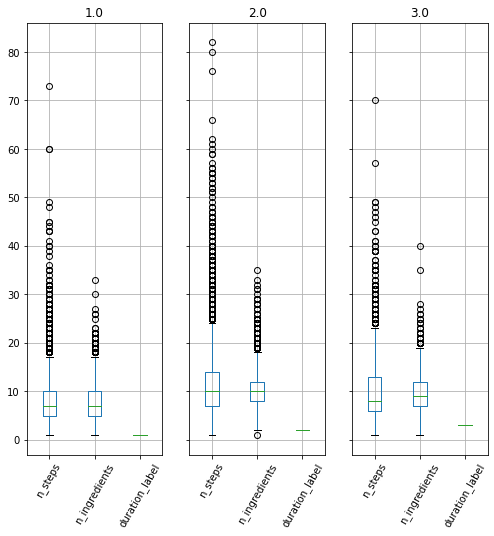

In [37]:
data_train.groupby("duration_label").boxplot(subplots=True, rot=60, figsize=(8,8), layout=(1,3))

# split data using holdout / cross-validation
#### need to provide model with some unseen data to avoid having unreasonably high prediction    
- train set: label know to model and human (for model training)
- develop set: label known to human only (for model selection)
- test set: label unknown to model and human ('recipe_test.csv' they provided)  

In [9]:
# convert list of strings to a long string for later text processing
data_train['steps'] = data_train['steps'].apply(' '.join)
data_train['ingredients'] = data_train['ingredients'].apply(' '.join)
data_train['steps'][0]

'in saucepan , melt margarine and combine with olive oil add celery & onion and saute until tender add garlic for the last minute add carrots , broth , rice and pepper and bring to a boil reduce heat , cover , and simmer for 35 minutes , or until rice is tender stir in chicken and parsley , cover , and simmer for 5 minutes longer or until heated through'

In [8]:
# split into train and dev set
# dev set is for model selection (use unseen labelled data to measure model performance)
from sklearn.model_selection import train_test_split
x_train, x_dev, y_train, y_dev = train_test_split(data_train.drop(columns='duration_label'), data_train['duration_label'], test_size=0.25, random_state=42)
x_train.shape, x_dev.shape, y_train.shape, y_dev.shape

((30000, 5), (10000, 5), (30000,), (10000,))

## use 30000 instances in training model
#### couldn't use preprocessed features teacher provided as these are trained by 40000 instances
#### if using those provided on testing 10000 instances,prediction will be higher than it should be (bc model already seen those 10000 while training)
#### workaround : not split 40000 and use test.csv provided --> then use kaggle accuracy for model selection --> but it will be overfit for kaggle

# use oversampling for train 

In [10]:
oversample = RandomOverSampler(sampling_strategy='minority')
x_train, y_train = oversample.fit_resample(x_train, y_train)
x_train.shape

(45510, 5)

# build own countvectorizer -- task --> oversampling on train and tell result tmr
### why:
- the one provided by instructor contains info in dev set, so it affects model evaluation 
- we need to tune some hyperparameters
But can use during final submission --> fit the final model and make predictions for kaggle

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
# stop_word ='english' means deleting some common words like the, a,.... in list 'english'
cv = CountVectorizer(stop_words='english').fit(x_train['steps'])
vocab_dict = cv.vocabulary_
print('how many differnent vocab: ', len(vocab_dict))
list(vocab_dict.items())[:5] #check first 5
# ('vocab', index of vocab)

how many differnent vocab:  15717


[('cook', 3671),
 ('chopped', 3130),
 ('onion', 9472),
 ('transparent', 14488),
 ('small', 12713)]

In [44]:
cv.get_feature_names()[3671]

'cook'

In [16]:
vocab = np.array(cv.get_feature_names())
vocab[3671]

'cook'

# sparse matrix i did 
### --> similar to provided 'recipe_text_feature_countvec' but with 30000 instances instead of 40000

In [12]:
# sparse matrix
x_train_steps_cv = cv.transform(x_train['steps'])
x_dev_steps_cv = cv.transform(x_dev['steps'])
print(x_train_steps_cv)
# row 0 col 982 has 2 --> first instance (index 0) , word number 982, count 2
# row 0 col 2103 has 1....

  (0, 982)	2
  (0, 2103)	1
  (0, 2108)	1
  (0, 2208)	1
  (0, 2331)	1
  (0, 3130)	1
  (0, 3439)	1
  (0, 3638)	2
  (0, 3671)	3
  (0, 3876)	1
  (0, 4673)	1
  (0, 4813)	1
  (0, 5683)	1
  (0, 6618)	1
  (0, 6724)	1
  (0, 7203)	1
  (0, 7769)	2
  (0, 8173)	1
  (0, 8516)	1
  (0, 8517)	3
  (0, 8537)	1
  (0, 8751)	1
  (0, 9404)	1
  (0, 9472)	1
  (0, 10061)	1
  :	:
  (45509, 3876)	2
  (45509, 4005)	1
  (45509, 4531)	1
  (45509, 4580)	1
  (45509, 5548)	1
  (45509, 5650)	1
  (45509, 5744)	1
  (45509, 5748)	1
  (45509, 6429)	1
  (45509, 6895)	1
  (45509, 6907)	1
  (45509, 7487)	1
  (45509, 7881)	1
  (45509, 8751)	1
  (45509, 9472)	1
  (45509, 9611)	2
  (45509, 10307)	1
  (45509, 10312)	1
  (45509, 10626)	1
  (45509, 11255)	1
  (45509, 11791)	1
  (45509, 12218)	1
  (45509, 12915)	1
  (45509, 13036)	1
  (45509, 13360)	1


In [54]:
# recheck above cell
import re
print(vocab[982])
re.findall(vocab[982], x_train['steps'].iloc[0])

add


['add', 'add']

# base model 
### use multinomial NB which is suitable for count features
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
### in above link, it says:
#### The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for !!!!! text classification).!!!!!!!

In [13]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB() # may need to chooose parameters later?
#train it on feature 'steps'     y_train is label
mnb.fit(x_train_steps_cv, y_train)
mnb.score(x_train_steps_cv, y_train), mnb.score(x_dev_steps_cv, y_dev)

(0.7750384530872336, 0.6968)

### check feature importance using MNB

In [14]:
#mnb.coef_.shape
most_important = np.argsort(mnb.feature_log_prob_, axis=-1)[:,::-1][:,:20]
most_important
# tells us index of most frequent words (biggest log likelihood) for 3 labels

array([[  982,  8751,  6724, 13364,  2208,  3671,  8796,  8817, 12217,
        10307,  9404, 11821,  8537,  9768,  7203,  3439,  2546, 10061,
         7769,  2980],
       [ 8751,   982,  6724,  9768,  8817,  9611, 13364,  2208,  1650,
         3671,  8796, 11821, 10307,  2546,  7769,  1666, 13576,  3034,
         8537,  9404],
       [  982,  6908,  3671,  3817, 10307,  8751,  6724, 13364,  8173,
        15209,  2208, 10510,  8817, 10554,  8796, 11894,  3034,  8515,
        11821, 11365]], dtype=int64)

In [17]:
for i in range(len(most_important)):
    print(vocab[most_important[i]])
#MNB use what kind of word to do predictions (words with biggest log likelihood)
# but words like 'add' are not useful --> that's why accracy is around 0.7?

['add' 'minutes' 'heat' 'stir' 'bowl' 'cook' 'mix' 'mixture' 'serve'
 'place' 'oil' 'salt' 'medium' 'pan' 'ingredients' 'combine' 'butter'
 'pepper' 'large' 'cheese']
['minutes' 'add' 'heat' 'pan' 'mixture' 'oven' 'stir' 'bowl' 'bake' 'cook'
 'mix' 'salt' 'place' 'butter' 'large' 'baking' 'sugar' 'chicken' 'medium'
 'oil']
['add' 'hours' 'cook' 'cover' 'place' 'minutes' 'heat' 'stir' 'low'
 'water' 'bowl' 'pot' 'mixture' 'pour' 'mix' 'sauce' 'chicken' 'meat'
 'salt' 'remove']


# better options for preprocessing 
## n-grams --> combine 2 words together (we were using 1-gram but now 2-grams)

In [18]:
cv2 = CountVectorizer(stop_words='english', ngram_range=(1,2))
cv2.fit(x_train['steps'])
vocab_dicts2 = cv2.vocabulary_
print(len(vocab_dicts2)) #number of differnent combo of 1 and 2 vocabs
list(vocab_dicts2.items())[0:5]

360300


[('cook', 72687),
 ('chopped', 60474),
 ('onion', 208255),
 ('transparent', 336460),
 ('small', 291832)]

In [19]:
vocab2 = np.array(cv2.get_feature_names())
# sparse matrix
x_train_steps_cv2 = cv2.transform(x_train['steps'])
x_dev_steps_cv2 = cv2.transform(x_dev['steps'])
mnb2 = MultinomialNB()
#train it on feature 'steps'     y_train is label
mnb2.fit(x_train_steps_cv2, y_train)
mnb2.score(x_train_steps_cv2, y_train), mnb2.score(x_dev_steps_cv2, y_dev)

(0.9141507361019556, 0.7278)

In [20]:
#check if overfit:
from sklearn.model_selection import cross_val_score
cross_val_score(mnb2, x_train_steps_cv2, y_train)

array([0.81817183, 0.82322566, 0.81256867, 0.82289607, 0.8441002 ])

In [21]:
most_important = np.argsort(mnb2.feature_log_prob_, axis=-1)[:,::-1][:,:20]
for i in range(len(most_important)):
    print(vocab2[most_important[i]])
# we can see that not different from 1-gram....

['add' 'minutes' 'heat' 'stir' 'bowl' 'cook' 'mix' 'mixture' 'serve'
 'place' 'oil' 'salt' 'medium' 'pan' 'ingredients' 'combine' 'butter'
 'pepper' 'large' 'cheese']
['minutes' 'add' 'heat' 'pan' 'mixture' 'oven' 'stir' 'bowl' 'bake' 'cook'
 'mix' 'salt' 'place' 'butter' 'large' 'baking' 'sugar' 'chicken' 'medium'
 'oil']
['add' 'hours' 'cook' 'cover' 'place' 'minutes' 'heat' 'stir' 'low'
 'water' 'bowl' 'pot' 'mixture' 'pour' 'mix' 'sauce' 'chicken' 'meat'
 'salt' 'remove']


### from above accuracy, accuracy for dev set is still similar with 1-gram, and we use cross validation to check, accuracy for training is still around 0.72.... so training set is overfit.....
## conclusion : not using 2-gram with MNB bc not imporving accuracy

# tfidf
### combines countvectorizer and tfidftransformer

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english').fit(x_train['steps'])
vocab_dict_tfidf = tfidf.vocabulary_
print(len(vocab_dict_tfidf)) #number of differnent combo of 1 and 2 vocabs
vocab_tfidf = np.array(tfidf.get_feature_names())
x_train_steps_tfidf = tfidf.transform(x_train['steps'])
x_dev_steps_tfidf = tfidf.transform(x_dev['steps'])
x_train_steps_tfidf


15717


<45510x15717 sparse matrix of type '<class 'numpy.float64'>'
	with 1984745 stored elements in Compressed Sparse Row format>

In [23]:
mnb.fit(x_train_steps_tfidf, y_train)
mnb.score(x_train_steps_tfidf, y_train), mnb.score(x_dev_steps_tfidf, y_dev), 

(0.7610195561415074, 0.6874)

# LinearSVC, Logistic regression, SGDClassifier

In [24]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [25]:
svc = LinearSVC().fit(x_train_steps_cv, y_train)
svc.score(x_train_steps_cv, y_train), svc.score(x_dev_steps_cv, y_dev)
# error bc model not trained well --> overfit !!!

C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


(0.945506482091848, 0.7515)

In [26]:
svc = LinearSVC().fit(x_train_steps_tfidf, y_train)
svc.score(x_train_steps_tfidf, y_train), svc.score(x_dev_steps_tfidf, y_dev)

(0.9105691056910569, 0.7632)

# Logisticregression on cv v.s. on tfidf

In [27]:
lr = LogisticRegression(max_iter=1000).fit(x_train_steps_cv, y_train)
lr.score(x_train_steps_cv, y_train), lr.score(x_dev_steps_cv, y_dev)

(0.9310920676774336, 0.7675)

In [28]:
lr = LogisticRegression(max_iter=1000).fit(x_train_steps_tfidf, y_train)
lr.score(x_train_steps_tfidf, y_train), lr.score(x_dev_steps_tfidf, y_dev)

(0.8774555042847726, 0.7717)

## conclusion:
### from above, can see that tfidf is better to use for above models

# scaling the data?? --> not sure and tfidf already kind of scaled the data

# feature selection

In [29]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif

### use mutual_info(discrete) for count features

In [30]:
# choose 4000 features to check mutual info btw label and each feature --> higher better
kbest = SelectKBest(score_func=mutual_info_classif, k=4000).fit(x_train_steps_cv, y_train)

In [31]:
top20 = kbest.scores_.argsort()[::-1][:20]
vocab[top20]
# get array(['hours', 'bake', 'minutes', 'oven', '30',.......])

array(['hours', 'low', 'crock', 'bake', 'minutes', 'cooker', 'cover',
       'slow', 'oven', 'pot', 'cook', '350', 'baking', 'preheat',
       'crockpot', '30', 'meat', 'overnight', 'butter', 'degrees'],
      dtype='<U30')

### use f_classif(default --accept continuous features) or chi2(non-negative features) on tfidf

In [32]:
kbest = SelectKBest(score_func=chi2, k=4000).fit(x_train_steps_tfidf, y_train)
top20 = kbest.scores_.argsort()[::-1][:20]
vocab[top20]

array(['hours', 'crock', 'cooker', 'slow', 'low', 'pot', 'crockpot',
       'roast', 'meat', 'bake', 'cover', '350', 'oven', 'beef', 'minutes',
       'setting', 'baking', 'pork', '40', 'overnight'], dtype='<U30')

In [33]:
# f_classif(default)
kbest = SelectKBest(k=4000).fit(x_train_steps_tfidf, y_train)
top20 = kbest.scores_.argsort()[::-1][:20]
vocab[top20]

array(['hours', 'low', 'crock', 'bake', 'minutes', 'cover', 'cooker',
       'slow', 'pot', 'oven', '350', 'cook', 'preheat', 'baking', 'high',
       '30', 'crockpot', 'meat', '40', 'overnight'], dtype='<U30')

### conclusion:
#### pretty similar result of top20

# will inspect these later :
# ppl said grid search is good to use!
## !!!grid search !!!!    pipeline for classifier and could change parameters (differnetn classifiers and different feature selection and cross validation) --> they said SVC with feature 10000 is good?

(pipline combines a text feature extractor with a simple classifier)

## SGDClassifier --? 

# grid search
#### create a pipline to do feature selection and fitting model
#### use grid search to find the best hyperparameter set for this pipline

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# SGD classifier
### this one can mimic linearSVC and logistic regression by giving different loss function but it uses stochastic gradient descent to train
### adv: fast
### disadv: random, may not converge to optimun, but still good


In [35]:
sgd = SGDClassifier(loss='log', max_iter=1000, random_state=42).fit(x_train_steps_tfidf, y_train)
sgd.score(x_train_steps_tfidf, y_train), sgd.score(x_dev_steps_tfidf, y_dev)

(0.8270929466051418, 0.7622)

In [36]:
pipeline = Pipeline(
[
    ('kbest', SelectKBest()), ('clf', SGDClassifier(random_state=30027))
])

In [37]:
parameters ={
    'kbest__score_func':(f_classif, chi2),
    'kbest__k':(1000, 4000, 10000, 'all'),
    'clf__loss':('hinge', 'log'), #hinge loss : linearsvc; log loss: logistic regression
    'clf__alpha':(1e-5, 1e-4, 1e-3, 1e-2), #regalarisation/penulty, similar to C in linearSVC
}

In [38]:
from time import time
def grid_search(pipeline, parameters, X, y):
    gs = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=1)
    print("Performing grid search")
    print("pipeline", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time()
    gs.fit(X, y)
    print("done in %0.3fs" %(time() - t0))
    
    # print out best 5 results
    mean_score = gs.cv_results_['mean_test_score']
    param_set = gs.cv_results_['params']
    for idx in mean_score.argsort()[-5:]:
        print(param_set[idx])
        print(gs.cv_results_['mean_test_score'][idx])
        print("="*30)
    return gs

In [39]:
results = grid_search(pipeline, parameters, x_train_steps_tfidf, y_train)


Performing grid search
pipeline ['kbest', 'clf']
parameters:
{'kbest__score_func': (<function f_classif at 0x000001A8637801F0>, <function chi2 at 0x000001A863780310>), 'kbest__k': (1000, 4000, 10000, 'all'), 'clf__loss': ('hinge', 'log'), 'clf__alpha': (1e-05, 0.0001, 0.001, 0.01)}
Fitting 5 folds for each of 64 candidates, totalling 320 fits
done in 128.959s
{'clf__alpha': 1e-05, 'clf__loss': 'log', 'kbest__k': 10000, 'kbest__score_func': <function chi2 at 0x000001A863780310>}
0.8450670182377499
{'clf__alpha': 1e-05, 'clf__loss': 'hinge', 'kbest__k': 10000, 'kbest__score_func': <function chi2 at 0x000001A863780310>}
0.8470446055811911
{'clf__alpha': 1e-05, 'clf__loss': 'hinge', 'kbest__k': 10000, 'kbest__score_func': <function f_classif at 0x000001A8637801F0>}
0.8471105251593057
{'clf__alpha': 1e-05, 'clf__loss': 'hinge', 'kbest__k': 'all', 'kbest__score_func': <function chi2 at 0x000001A863780310>}
0.8479894528675016
{'clf__alpha': 1e-05, 'clf__loss': 'hinge', 'kbest__k': 'all', 'kbe

## conclusion
1.k-10000 is better     
2.score function doesn't matter    
3.hinge loss is generally better than log -> svc may be better     
4.best regularisation term (alpha) is 1e-4    

## use svc to demonstrate other tuning methods with visualization
### if have 2 parameters to tune, maybe a heatmap to visualise


In [40]:
pipeline = Pipeline(
[
    ('kbest', SelectKBest()), ('clf', LinearSVC(max_iter=1000))
])
parameters = {
    'kbest__k': (4000, 6000, 8000, 10000, 'all'),
    'clf__C': (0.01, 0.1, 0.3, 0.5, 10),
}
gs = grid_search(pipeline, parameters, x_train_steps_tfidf, y_train)

Performing grid search
pipeline ['kbest', 'clf']
parameters:
{'kbest__k': (4000, 6000, 8000, 10000, 'all'), 'clf__C': (0.01, 0.1, 0.3, 0.5, 10)}
Fitting 5 folds for each of 25 candidates, totalling 125 fits
done in 237.002s
{'clf__C': 10, 'kbest__k': 6000}
0.8452428037793892
{'clf__C': 0.3, 'kbest__k': 'all'}
0.845506482091848
{'clf__C': 0.5, 'kbest__k': 8000}
0.8456383212480774
{'clf__C': 0.5, 'kbest__k': 10000}
0.8458580531751263
{'clf__C': 0.5, 'kbest__k': 'all'}
0.8475939353988136


In [118]:
import seaborn as sns
scores = gs.cv_results_['mean_test_score'].reshape((6, 5))
sns.heatmap(scores, xticklabels=parameters['kbest__k'], yticklabels=parameters['clf__C'], cmap="Blues")

ValueError: cannot reshape array of size 25 into shape (6,5)

# ???? do seaborn again later

# one parameter to tune --> maybe a validation curve


In [41]:
from sklearn.model_selection import validation_curve
kbest = SelectKBest(k=6000).fit(x_train_steps_tfidf, y_train)
x_train_steps_tfidf_6k = kbest.transform(x_train_steps_tfidf)
x_dev_steps_tfidf_6k = kbest.transform(x_dev_steps_tfidf)

In [42]:
param_range = np.logspace(-2, 2, 10)

train_scores, validation_scores = validation_curve(LinearSVC(max_iter=1000), x_train_steps_tfidf_6k, y_train, param_name='C', param_range=param_range, cv=5, n_jobs=-1, verbose=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  50 | elapsed:    2.9s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.8min finished


In [43]:
mean_train_scores = np.mean(train_scores, axis=1)
std_train_scores = np.std(train_scores, axis=1)
mean_valid_scores = np.mean(validation_scores, axis=1)
std_valid_scores = np.std(validation_scores, axis =1)

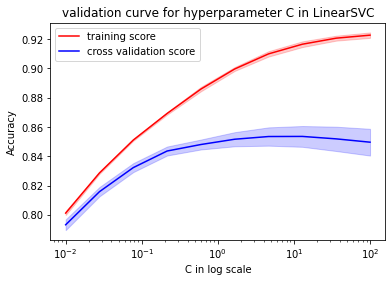

In [44]:
plt.semilogx(param_range, mean_train_scores, label="training score", color = 'r')
plt.fill_between(param_range, mean_train_scores - std_train_scores, mean_train_scores + std_train_scores, alpha=0.2, color='r')
plt.semilogx(param_range, mean_valid_scores, label="cross validation score", color = 'b')
plt.fill_between(param_range, mean_valid_scores - std_valid_scores, mean_valid_scores + std_valid_scores, alpha=0.2, color='b')
plt.legend(loc="best")
plt.title("validation curve for hyperparameter C in LinearSVC")
plt.xlabel("C in log scale")
plt.ylabel("Accuracy")
plt.show()


In [45]:
best_C = param_range[mean_valid_scores.argmax()]
best_C

12.915496650148826

## conclusion:
higher C means higher training accuracy, which is reasonble bc higher C means harder margin (not allow error)
validation accuracy starts to drop btw 1e-1 to 0

# learning curve -- check overfitiing
### by adding more and more data, check if that model needs more data or reach max accuracy at some point
### should reach max accuracy with 40000 instances
#### bigger gap --> more overfit

In [46]:
from sklearn.model_selection import learning_curve
train_size, train_scores, validation_scores = learning_curve(LinearSVC(C=best_C, max_iter=1000), x_train_steps_tfidf_6k, y_train, train_sizes=np.linspace(0.1, 1, 5),cv=5, n_jobs=-1, verbose=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  25 | elapsed:    2.9s remaining:   34.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.0min finished


In [47]:
mean_train_scores = np.mean(train_scores, axis=1)
std_train_scores = np.std(train_scores, axis=1)
mean_valid_scores = np.mean(validation_scores, axis=1)
std_valid_scores = np.std(validation_scores, axis =1)

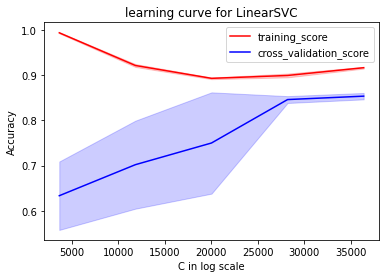

In [48]:
plt.plot(train_size, mean_train_scores, label="training_score", color='r')
plt.fill_between(train_size, mean_train_scores - std_train_scores, mean_train_scores + std_train_scores, alpha=0.2, color='r')
plt.plot(train_size, mean_valid_scores, label="cross_validation_score", color='b')
plt.fill_between(train_size, mean_valid_scores - std_valid_scores, mean_valid_scores + std_valid_scores, alpha=0.2, color='b')

plt.legend(loc="best")
plt.title("learning curve for LinearSVC")
plt.xlabel("C in log scale")
plt.ylabel("Accuracy")
plt.show()

# conclusion
### some overfitting as indicated by gap btw trainning and validation

# doc2vec
## train a vect representation for each word --> similarity of words (very abstract)
### each word there is 50 dimesnion --> is this word describing animal, human, job,....

In [49]:
x_doc2vec = pd.read_csv(name_folder + "/recipe_text_features_doc2vec100/train_steps_doc2vec100.csv", header=None)
x_doc2vec
### cross validation score for each model
# cross_val_score(logisticregression, doc2vect, y).......

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.038488,-0.061193,0.185614,0.108549,-0.544672,-0.346892,-0.364900,-0.131785,-0.268178,-0.378723,...,-0.046046,-1.237815,0.337203,-0.478054,0.325911,0.956001,-0.016299,0.047190,-1.078757,-0.603840
1,-0.346682,0.818242,-1.485725,-0.136444,-0.839452,-0.028747,0.359066,-0.360245,0.898010,0.034255,...,-0.050925,-0.754784,-0.414631,-1.401076,0.140092,-0.593359,0.859226,0.172982,-0.032898,-0.066318
2,-0.161517,-0.046478,-0.469720,0.856473,0.254552,0.963018,0.025045,-0.592293,0.092916,-0.088357,...,0.728282,-0.297418,-0.316859,-0.140749,0.103697,0.744142,-0.445749,-0.235873,0.653200,-0.108352
3,-0.149138,-0.435168,0.398795,0.162542,0.062735,-0.489047,-0.407908,-0.367520,0.117337,0.352653,...,-0.898283,0.477606,-0.352423,-0.607715,0.917631,0.211922,0.168028,-0.274200,-0.593518,-0.655954
4,-0.104086,0.423679,-0.432812,-0.721857,-0.464891,0.179705,0.441417,0.030490,0.080929,-0.981135,...,0.156563,0.106496,-0.449400,-0.177187,0.419978,-0.673034,1.046548,-0.431546,-0.109882,0.228147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0.447364,0.079168,-0.056656,-0.241829,-0.448888,-0.198237,1.525208,0.202437,-0.510281,0.198008,...,0.189909,0.501349,0.219873,0.338590,0.204403,0.633901,0.202228,0.268780,-0.752346,-0.585481
39996,0.382064,0.291208,-0.504445,-1.015946,0.255569,0.833729,0.185583,-0.631126,-0.159072,0.706208,...,0.744043,0.949267,0.921160,-0.920896,-0.010590,-0.737633,-1.056501,0.675061,-0.850657,-0.424602
39997,-0.308860,0.984259,-0.456285,-0.245439,-0.331528,-0.854780,-0.254259,-0.034312,-0.238043,0.000716,...,0.026969,-0.494188,-0.725943,-0.377076,-0.228925,-0.092484,0.429468,-0.036762,-0.291253,0.279832
39998,0.106077,0.089861,-0.463742,-0.865867,-0.432115,1.221770,-0.375783,-0.484293,-0.526171,0.049754,...,-0.135346,-0.725684,0.501711,-0.143399,-0.341598,-0.770968,0.342341,0.140158,-0.511545,-0.937076


In [50]:
y= data_train['duration_label'] # all labels in training set


In [51]:
from sklearn.naive_bayes import GaussianNB
cross_val_score(GaussianNB(), x_doc2vec, y)

array([0.604125, 0.594375, 0.61175 , 0.601   , 0.605   ])

In [52]:
cross_val_score(LogisticRegression(max_iter=200), x_doc2vec, y)

array([0.6715  , 0.66225 , 0.672625, 0.66575 , 0.67725 ])

In [53]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(32,), early_stopping=True)
mlp.fit(x_doc2vec, y)
mlp.score(x_doc2vec, y)

0.730025

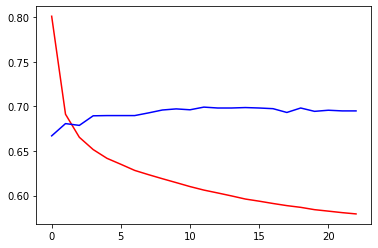

In [54]:
plt.plot(mlp.loss_curve_, color='r')
plt.plot(mlp.validation_scores_, color = 'b')

# other possible things to do
1. combine names/steps/ingredients (concatenate doc2vec vectors, combines as one very long text then use countvector or even train 3 seperate models and use voting)
could use pca to visualise
try to use pytorch/keras/tenserflow
2. ensemble models (random forest, adaboost, gradientboost, etc) or build stacking model using base classifers (need sklearn emsemble for all these models
3. try deep learning

# ensemble method
## stacking:
have multiple classifiers -- put them in a box --> from that box output a prediction from each classfier--> pass to final classifier (meta-classifier that will be used to find final prediction from your data)
take each individual classifier -- perform prediction -- calculate why predict ...... -- from these why predicts build a matrix for each classifier and then pass matrix to final classifier and gives u final why predict --> use final why predict to calculate prediction accuracy
## bagging:
bagging (different from stacking bc it does random sampling)
bagging and stacking are similar in procedure, but bagging --> u need to randomly smaple total number of instances and features
then pass that particular data to a classifer whcih gives u some accuracy --> then pass same size of another isntance to another classifier
that classfier gives u another accuracy
in the end, there is voting which give classifier with highest accuracy been chosen as final output score
why random sampling -->
for iris, we r clear about data, but if work with other data, difficult to manage
maintan randomness and avoid overfitiing by too much looking at same sample, keep running all algo...
that's why random sampling is important in bagging
## boosting:
increases number of instances classifers got wrong and learn from those instances
one classifer makes mistakes then penulised --> try imporve accuracy of clasffier who performs weakly --> then build a overall powerful one
similar to bagging --> random sampling
differnecen --> boosting not cal final prediction at the end, it starts to cal prediction from the beginning/the first classifier
there is some criteria penalise those one performing low to boost their performance and cal predictions
## which one to use:
